In [2]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam
import keras_tuner as kt
from keras import regularizers
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

python(44019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
#-------------------------- import data --------------------------
dt_low = pd.read_csv("synthetic_low_var.csv") # low variance of response
dt_high = pd.read_csv("synthetic_high_var.csv") # high variance of response
dt_low.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,-0.483797,0.039510,1.605737,-1.051738,1.486305,1,9,0.557112,8,...,0.030776,0.294315,-1.340546,-0.314284,1.629798,0.786952,-1.468209,1.596671,1.633455,88.799939
1,0.400157,1.288057,0.338378,-1.094710,0.139810,-0.472753,2,2,0.306162,2,...,-1.884621,0.378655,-0.328241,-1.220533,-0.044359,-1.906470,0.400609,0.844772,-1.041063,378.567569
2,0.978738,-0.129879,-0.842183,1.258372,-1.098722,1.417341,1,6,-1.548351,1,...,0.813645,-0.053506,2.304177,-1.375100,0.850467,1.756041,-0.890877,0.216188,-0.132376,46.871694
3,2.240893,-0.198078,-0.049632,1.458091,1.179987,0.884993,1,0,-1.143150,0,...,-0.081434,0.442991,2.144848,0.763189,0.498802,0.378477,0.347638,-0.654237,-1.496598,1541.502049
4,1.867558,-0.334488,-1.230245,-0.292203,-1.110670,0.043346,2,0,0.587846,2,...,-0.866605,-0.201010,0.486937,1.478314,-0.469760,0.237734,-1.551604,-0.085676,-0.434549,2701.132289


In [4]:
#-------------------------- remove outliers - low variance --------------------------
log_claim = np.log(dt_low['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_low_cleaned = dt_low[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_low_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,-0.483797,0.039510,1.605737,-1.051738,1.486305,1,9,0.557112,8,...,0.030776,0.294315,-1.340546,-0.314284,1.629798,0.786952,-1.468209,1.596671,1.633455,88.799939
1,0.400157,1.288057,0.338378,-1.094710,0.139810,-0.472753,2,2,0.306162,2,...,-1.884621,0.378655,-0.328241,-1.220533,-0.044359,-1.906470,0.400609,0.844772,-1.041063,378.567569
2,0.978738,-0.129879,-0.842183,1.258372,-1.098722,1.417341,1,6,-1.548351,1,...,0.813645,-0.053506,2.304177,-1.375100,0.850467,1.756041,-0.890877,0.216188,-0.132376,46.871694
3,2.240893,-0.198078,-0.049632,1.458091,1.179987,0.884993,1,0,-1.143150,0,...,-0.081434,0.442991,2.144848,0.763189,0.498802,0.378477,0.347638,-0.654237,-1.496598,1541.502049
4,1.867558,-0.334488,-1.230245,-0.292203,-1.110670,0.043346,2,0,0.587846,2,...,-0.866605,-0.201010,0.486937,1.478314,-0.469760,0.237734,-1.551604,-0.085676,-0.434549,2701.132289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.337715,0.271827,0.292195,0.605058,1.423109,0.141540,1,7,2.277038,9,...,2.066959,-0.595774,0.173455,-2.027848,-0.946148,-1.023459,0.688556,0.877700,-0.179507,623.722217
99996,-2.028548,0.050507,0.658467,-0.390804,0.574836,0.793723,1,6,-0.023771,6,...,0.788700,0.795987,1.556792,-1.824903,0.318298,0.326068,0.124877,-0.895828,1.110726,93.784832
99997,0.726182,0.667815,0.294777,1.238386,-0.480699,0.553182,2,3,1.091213,7,...,-1.190954,0.526202,-0.347125,-1.543004,-0.502135,-1.291067,0.639055,-0.388257,1.598084,1489.773427
99998,-1.167831,-1.021195,2.118626,-0.125306,-0.609619,1.625515,1,8,0.991542,8,...,1.108416,0.317347,0.316814,-0.012602,-0.942454,-1.123440,0.306925,0.778969,0.562401,30.227782


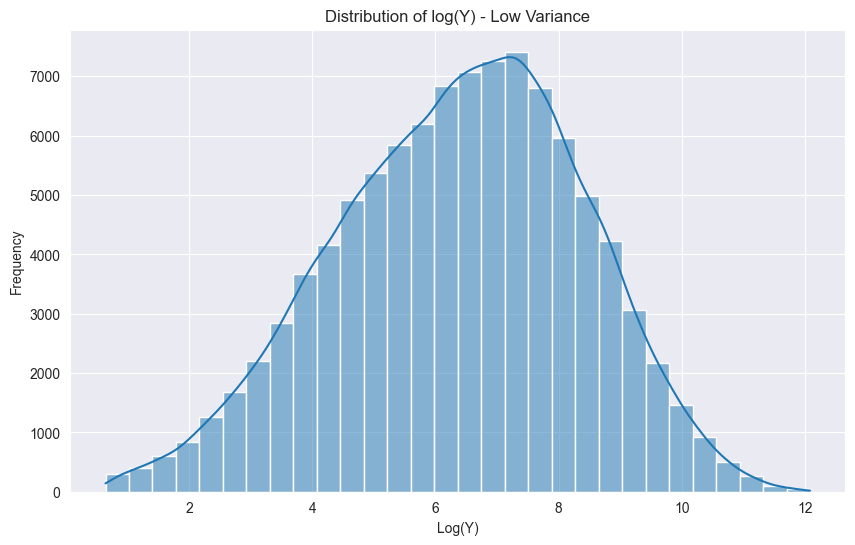

In [5]:
#-------------------------- distribution of log(response) - low variance --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_low_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y) - Low Variance')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [6]:
#-------------------------- remove outliers - high variance --------------------------
log_claim = np.log(dt_high['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_high_cleaned = dt_high[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_high_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,-0.483797,0.039510,1.605737,-1.051738,1.486305,1,9,0.557112,8,...,0.030776,0.294315,-1.340546,-0.314284,1.629798,0.786952,-1.468209,1.596671,1.633455,35.391872
1,0.400157,1.288057,0.338378,-1.094710,0.139810,-0.472753,2,2,0.306162,2,...,-1.884621,0.378655,-0.328241,-1.220533,-0.044359,-1.906470,0.400609,0.844772,-1.041063,8.021119
2,0.978738,-0.129879,-0.842183,1.258372,-1.098722,1.417341,1,6,-1.548351,1,...,0.813645,-0.053506,2.304177,-1.375100,0.850467,1.756041,-0.890877,0.216188,-0.132376,389.618064
3,2.240893,-0.198078,-0.049632,1.458091,1.179987,0.884993,1,0,-1.143150,0,...,-0.081434,0.442991,2.144848,0.763189,0.498802,0.378477,0.347638,-0.654237,-1.496598,404.945174
4,1.867558,-0.334488,-1.230245,-0.292203,-1.110670,0.043346,2,0,0.587846,2,...,-0.866605,-0.201010,0.486937,1.478314,-0.469760,0.237734,-1.551604,-0.085676,-0.434549,2324.292339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.720058,-1.751198,-0.249913,-1.220736,1.249073,0.933418,1,9,-0.151775,6,...,-0.882839,-0.136535,-1.473957,-1.377843,-0.459896,-0.120551,0.515516,-1.118934,-0.043026,215.306177
99995,-0.337715,0.271827,0.292195,0.605058,1.423109,0.141540,1,7,2.277038,9,...,2.066959,-0.595774,0.173455,-2.027848,-0.946148,-1.023459,0.688556,0.877700,-0.179507,342.840642
99996,-2.028548,0.050507,0.658467,-0.390804,0.574836,0.793723,1,6,-0.023771,6,...,0.788700,0.795987,1.556792,-1.824903,0.318298,0.326068,0.124877,-0.895828,1.110726,0.880997
99998,-1.167831,-1.021195,2.118626,-0.125306,-0.609619,1.625515,1,8,0.991542,8,...,1.108416,0.317347,0.316814,-0.012602,-0.942454,-1.123440,0.306925,0.778969,0.562401,17.188052


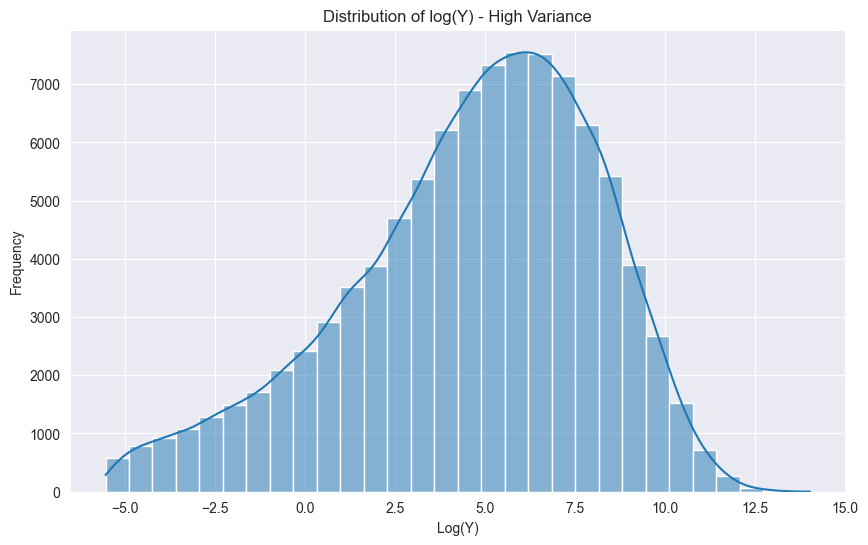

In [7]:
#-------------------------- distribution of log(response) - high variance --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_high_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y) - High Variance')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [8]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_low_cleaned.drop(["Y"], axis = 1), dt_low_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

cat_vars = ["X7", "X8", "X10"] # categorical features
all_vars = list(X_train.columns) # all features

### GAMINet approach

In [9]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(Lambda(lambda x: x - keras.ops.mean(x, axis=0, keepdims=True), output_shape=(1,))) # zero center all output
    return model

python(44020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


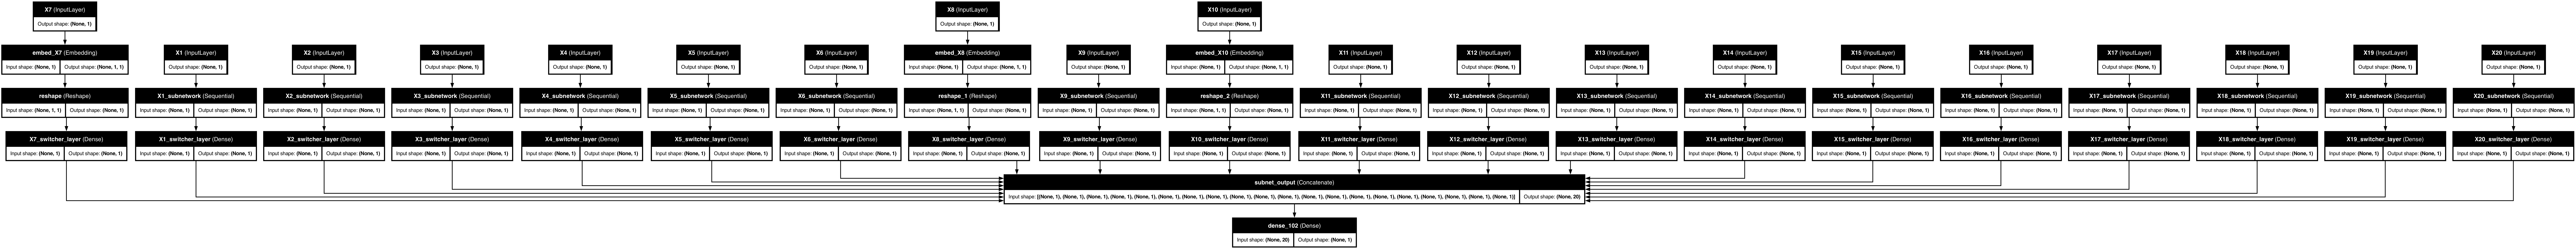

In [10]:
# -------------------------- create a NAM with main effects--------------------------
# for reproducibility
seed_value = 0
keras.utils.set_random_seed(seed_value)

# model architecture
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 40
num_layers = 5
activation = 'leaky_relu'

# main effect
for name in all_vars:

    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    if name in cat_vars: # numeric variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = dt_low_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
        switcher_layer = Dense(1, use_bias = False, kernel_initializer = Constant(1.0), trainable = False, name = f"{name}_switcher_layer")(embed_layer_reshape) # used for pruning later
        sub_outputs.append(switcher_layer)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, kernel_initializer = Constant(1.0), trainable = False, name = f"{name}_switcher_layer")(sub_output) # used for pruning later
        sub_outputs.append(switcher_layer)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = 'softplus')(subnets)

# final model
model_GAMI = Model(inputs = inputs, outputs = output_layer)

plot_model(model_GAMI, show_layer_names = True, show_shapes = True)

In [15]:
# -------------------------- compile and train the model --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    return keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))

# create training & validation data consistent with the model architecture
X_train_split = []
X_val_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])

# compile
model_GAMI.compile(optimizer = "adam", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

%time hist_main = model_GAMI.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 500, validation_data = (X_val_split, y_val))

Epoch 1/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 22108.9473 - root_mean_squared_error: 8285.4307 - val_loss: 20295.1309 - val_root_mean_squared_error: 7975.0317
Epoch 2/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 30927.3750 - root_mean_squared_error: 8274.0850 - val_loss: 14486.3428 - val_root_mean_squared_error: 7990.7354
Epoch 3/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18265.6035 - root_mean_squared_error: 8283.1855 - val_loss: 14486.0449 - val_root_mean_squared_error: 7989.3496
Epoch 4/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9157.8164 - root_mean_squared_error: 8281.8096 - val_loss: 14486.0303 - val_root_mean_squared_error: 7987.4004
Epoch 5/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9049.6123 - root_mean_squared_error: 8279.8594 - val_loss: 14486.0146 - val_root_mean_squared_error: 7985.3208
Epoch 6/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9049.5469 - root_mean_squared_error: 8277.8643 - val_loss: 1448

1862/1862 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


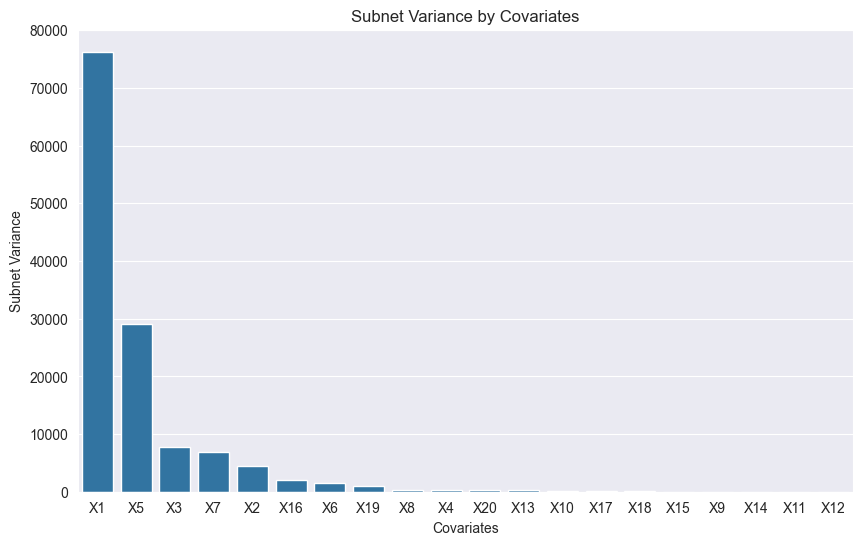

In [16]:
# -------------------------- quantify variable importance --------------------------

# Create a new model to get the output of the 'subnet_output' layer
subnet_output_layer = model_GAMI.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_GAMI.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split)

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i]))

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by="Subnet Variance", ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x="Covariates", y="Subnet Variance", data=varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

In [17]:
X_test_split = []
for i in range(len(X_test.columns)):
    X_test_split.append(X_test.iloc[:, i])

# -------------------------- create a null model --------------------------
# Set all switcher weights to zero for the null model
for layer in model_GAMI.layers:
    if 'switcher_layer' in layer.name:
        layer.set_weights([np.zeros_like(layer.get_weights()[0])])  # Set weights to zero

# Evaluate the null model on the test set
loss_list = []
null_loss = model_GAMI.evaluate(X_test_split, y_test, verbose=0)[1]
loss_list.append(null_loss)

# -------------------------- sequentially add variables --------------------------
# Get sorted covariates by importance
sorted_covariates = varimp_sorted["Covariates"].tolist()

# Add variables one by one in the order of importance
for covariate in sorted_covariates:
    # Find the corresponding switcher layer and set its weight to 1 (enable it)
    switcher_layer_name = f"{covariate}_switcher_layer"
    
    for layer in model_GAMI.layers:
        if layer.name == switcher_layer_name:
            layer.set_weights([np.ones_like(layer.get_weights()[0])])  # Enable the switcher for this covariate
    
    # Evaluate the updated model on the test set
    loss = model_GAMI.evaluate(X_test_split, y_test, verbose=0)[1]
    loss_list.append(loss)

# Return the list of loss values
loss_list

[8002.88232421875,
 7999.72705078125,
 7983.0517578125,
 7981.7236328125,
 7486.99560546875,
 7486.29248046875,
 7486.32421875,
 7486.35400390625,
 7486.38037109375,
 7409.2060546875,
 7409.15869140625,
 7409.1240234375,
 7409.130859375,
 7340.5791015625,
 7340.55712890625,
 7340.55078125,
 7340.55078125,
 7340.54638671875,
 7340.5478515625,
 7340.54736328125,
 7340.5478515625]

In [18]:
# -------------------------- select the model with the fewest variables --------------------------
# Find the minimum loss
min_loss = min(loss_list)
threshold = 0.01

# Find the smallest model with a loss within the threshold (min_loss + 0.01)
for i, loss in enumerate(loss_list):
    if loss <= min_loss + threshold:
        selected_model_index = i
        break  # Select the first such model with the fewest variables

# Get the selected variables
selected_variables = sorted_covariates[:i + 1]

# Return the list of loss values and the selected variables
selected_variables

['X1',
 'X5',
 'X3',
 'X7',
 'X2',
 'X16',
 'X6',
 'X19',
 'X8',
 'X4',
 'X20',
 'X13',
 'X10',
 'X17',
 'X18',
 'X15']

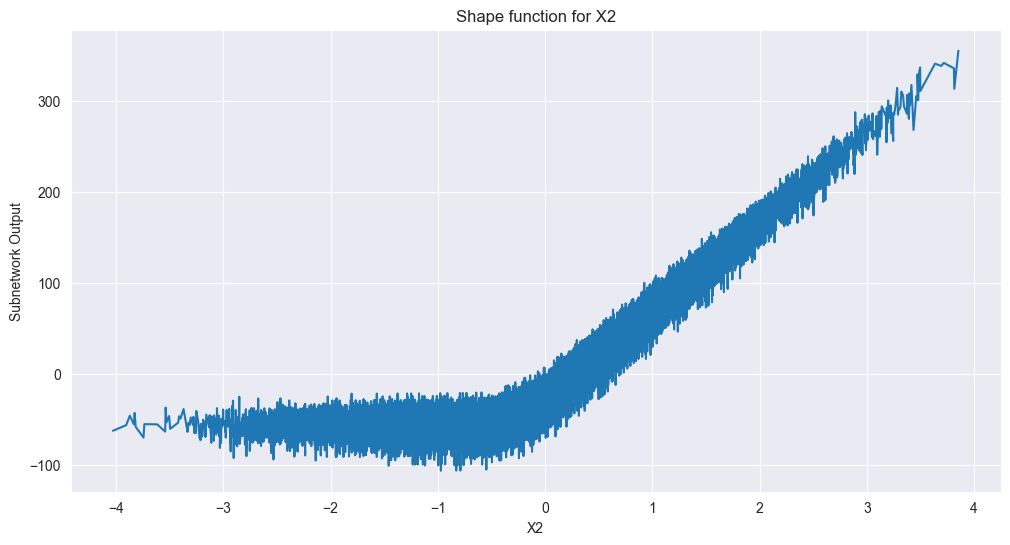

In [24]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X2"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], y = subnet_output_values[:,var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

### Sparse NAM with LASSO

In [27]:
# -------------------------- create a NAM with main effects --------------------------
# For reproducibility
seed_value = 289
keras.utils.set_random_seed(seed_value)

# Model architecture
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# Model hyperparameters
num_neurons = 40
num_layers = 5
activation = 'leaky_relu'

# Main effect
for name in all_vars:
    input_layer = Input(shape=(1,), name=name)
    inputs.append(input_layer)

    if name in cat_vars:  # Categorical variables
        # Categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = dt_low_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
        sub_outputs.append(embed_layer_reshape)
    else:  # Numeric variables
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork", trainable = False)
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# Combine subnets' outputs
subnets = Concatenate(name=f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = 'softplus', kernel_regularizer = regularizers.l1(0.01))(subnets)  # LASSO regularization (l1)

# Final model
model_SNAM = Model(inputs = inputs, outputs = output_layer)

In [28]:
# -------------------------- fit the model --------------------------
# compile
model_SNAM.compile(optimizer = "adam", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

# Train the model
model_SNAM.fit(X_train_split, y_train, epochs = 5_000, batch_size = 1_000, callbacks=[es], validation_data=(X_val_split, y_val))

Epoch 1/5000


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3970.9214 - root_mean_squared_error: 8276.2969 - val_loss: 3355.6912 - val_root_mean_squared_error: 8321.0029
Epoch 2/5000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3049.5151 - root_mean_squared_error: 8276.2158 - val_loss: 2491.3152 - val_root_mean_squared_error: 8320.8896
Epoch 3/5000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2260.9368 - root_mean_squared_error: 8276.0947 - val_loss: 1868.8519 - val_root_mean_squared_error: 8320.7412
Epoch 4/5000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1711.5259 - root_mean_squared_error: 8275.9443 - val_loss: 1463.2046 - val_root_mean_squared_error: 8320.5771
Epoch 5/5000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1354.6272 - root_mean_squared_error: 8275.7832 - val_loss: 1197.1803 - val_root_mean_squared_error: 8320.4092
Epoch 6/5000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1118.4366 - root_mean_squared_error: 8275.6201 - val_loss: 1014.7885 - val_root_mean_squared_error: 83

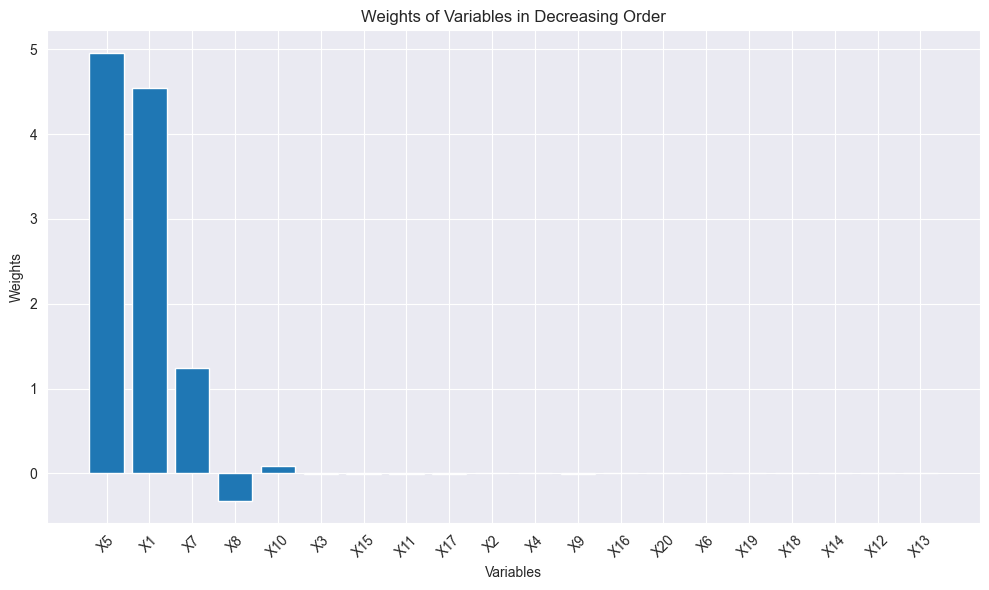

In [35]:
# -------------------------- get weights of the last layer --------------------------
last_layer_weights = model_SNAM.layers[-1].get_weights()[0]  # Extract weights from the last layer

# Combine variable names with corresponding weights
variable_weights = list(zip(all_vars, last_layer_weights.flatten()))  # Pair each variable with its corresponding weight

# Sort variables by their weights in decreasing order
sorted_weights = sorted(variable_weights, key=lambda x: abs(x[1]), reverse=True)

# Plotting the weights in decreasing order
variables, weight_values = zip(*sorted_weights)
plt.figure(figsize=(10, 6))
plt.bar(variables, weight_values)
plt.xlabel("Variables")
plt.ylabel("Weights")
plt.title("Weights of Variables in Decreasing Order")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

1862/1862 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


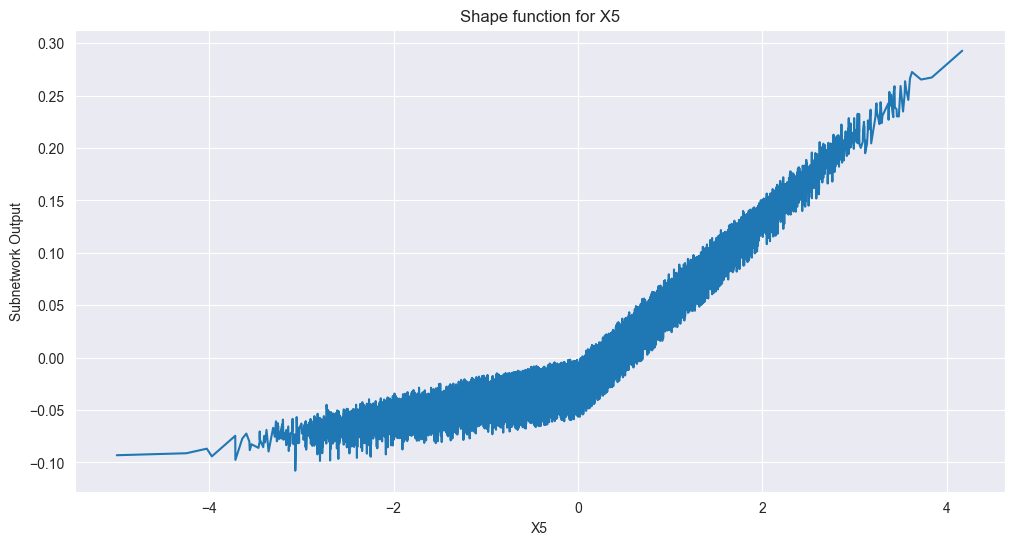

In [37]:
#-------------------------- view the shape function --------------------------
subnet_output_layer = model_SNAM.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_SNAM.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split)

# create the plot
var_name = "X5"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], y = subnet_output_values[:,var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

### Ensemble of NAM

In [31]:
def build_and_train_model(seed_value, data, X_train_split, y_train, X_val_split, y_val, all_vars):
    
    # different seeds come with different weight initialization
    keras.utils.set_random_seed(seed_value)

    # model architecture
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet

    # model hyperparameters
    num_neurons = 10
    num_layers = 1
    activation = 'sigmoid'

    # main effect
    for name in all_vars:

        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        if name in cat_vars: # numeric variables
            # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = dt_low_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
            sub_outputs.append(embed_layer_reshape)
        else:
            subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)
    output_layer = Dense(1)(subnets)

    # final model
    model_main = Model(inputs = inputs, outputs = output_layer)

    plot_model(model_main, show_layer_names = True, show_shapes = True)

    # compile
    model_main.compile(optimizer="adam", loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    es = EarlyStopping(restore_best_weights=True, patience=5)

    # fit the model
    model_main.fit(X_train_split, y_train, epochs=1000, callbacks=[es], validation_data=(X_val_split, y_val), verbose=0)
    
    subnet_output_layer = model_main.get_layer("subnet_output")  # Get the subnet output layer
    subnet_output_model = Model(inputs = model_main.inputs, outputs = subnet_output_layer.output)
    subnet_output_values = subnet_output_model.predict(X_train_split)

    # get the variance of each subnetwork across all data points
    subnet_variance = [np.var(subnet_output_values[:, i]) for i in range(subnet_output_values.shape[1])]
    
    return subnet_variance

In [32]:
# -------------------------- plot the variable importance --------------------------
num_models = 10
all_variances = []
seed_value = 1 # initial seed

for i in range(num_models):
    variances = build_and_train_model(seed_value + i, dt_low_cleaned, X_train_split, y_train, X_val_split, y_val, all_vars)
    all_variances.append(variances)

average_variances = np.mean(all_variances, axis = 0)

var_importance_ensemble = pd.DataFrame({"Covariates": covariates, "Subnet Variance": average_variances})

# Sort the DataFrame by subnet variance in decreasing order
varimp_ens_sorted = var_importance_ensemble.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_ens_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

2024-09-03 17:03:28.348072: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,19], In[1]: [20,1]
	 [[{{function_node __inference_one_step_on_data_1745569}}{{node functional_86_1/dense_347_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_86_1/dense_347_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/tupho/miniconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/tupho/miniconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/tupho/miniconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_31839/657838907.py", line 7, in <module>

  File "/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_31839/3647717740.py", line 45, in build_and_train_model

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 560, in call

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3445, in matmul

  File "/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

Matrix size-incompatible: In[0]: [32,19], In[1]: [20,1]
	 [[{{node functional_86_1/dense_347_1/MatMul}}]] [Op:__inference_one_step_on_iterator_1746024]